The data used in this notebook was sourced from this Kaggle Dataset: https://www.kaggle.com/datasets/rohit265/credit-card-eligibility-data-determining-factors 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cat
from xgboost import XGBClassifier

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import shap



/home/markc/Desktop/PythonProjects/NaturalLanguageProcessing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./dataset.csv')

First, let's begin with some basic examination of our data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [4]:
len(df) - len(df.drop_duplicates())

0

In [5]:
df.nunique()

ID                 9709
Gender                2
Own_car               2
Own_property          2
Work_phone            2
Phone                 2
Email                 2
Unemployed            2
Num_children          9
Num_family           10
Account_length       61
Total_income        263
Age                7172
Years_employed     3637
Income_type           5
Education_type        5
Family_status         5
Housing_type          6
Occupation_type      19
Target                2
dtype: int64

In [6]:
df.describe()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Target
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.348749,0.367700,0.671542,0.217427,0.287671,0.087548,0.174683,0.422804,2.182614,27.270059,1.812282e+05,43.784093,5.664730,0.132145
std,4.080270e+04,0.476599,0.482204,0.469677,0.412517,0.452700,0.282650,0.379716,0.767019,0.932918,16.648057,9.927731e+04,11.625768,6.342241,0.338666
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.700000e+04,20.504186,0.000000,0.000000
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.125000e+05,34.059563,0.928150,0.000000
50%,5.069449e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,26.000000,1.575000e+05,42.741466,3.761884,0.000000
75%,5.112986e+06,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,41.000000,2.250000e+05,53.567151,8.200031,0.000000
max,5.150479e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.000000,20.000000,60.000000,1.575000e+06,68.863837,43.020733,1.000000


Very interesting data here, some notable points, not all of which may be directly useful to our end analysis:
- Our target variable is pretty unbalanced, with only 13.2% of this sample being eligible for a credit card
- 67.2% of the sample owns a property (words given in the dataset definition, which I assume referes to real estate) but only 28.6% have an phone and only 36.8% own a car. This is not in line with my expectations and raises flags about potentially applying conclusions from this dataset. Where did this come from? When did this data come from? How was this data collected?
- Another oddity, the median age is 42.7 years but the median years of employment is less than 4. Even with stay-at-home spouses or similar explanations, this seems very odd. Will need to investigate further.
- If you subtract the given quantiles of Account_length from the given quantiles of Age, some of these people had to have had their accounts since their early to mid teenage years. Age of account opening could be an interesting feature to engineer.
- The 25th percentile of income is $112,500? But only 13.2% of people were eligible for a credit card? What currency is this? Was assuming dollars a bad choice?

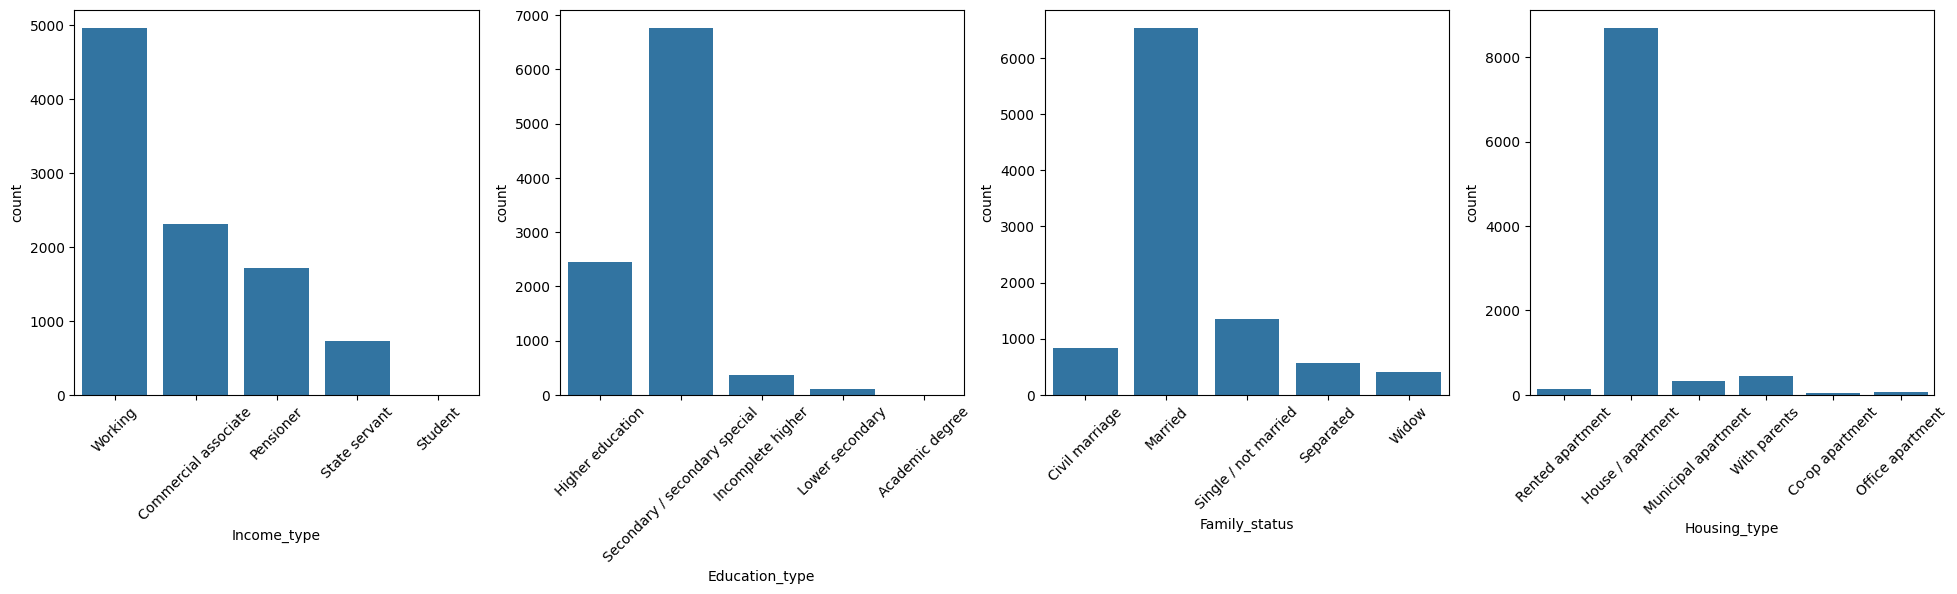

In [7]:

fig, ax = plt.subplots(1, 4, figsize=(24, 5))

sns.countplot(x='Income_type', data=df, ax=ax[0])
sns.countplot(x='Education_type', data=df, ax=ax[1])
sns.countplot(x='Family_status', data=df, ax=ax[2])
sns.countplot(x='Housing_type', data=df, ax=ax[3])

for i in range(4):
    ax[i].tick_params(axis='x', rotation=45)

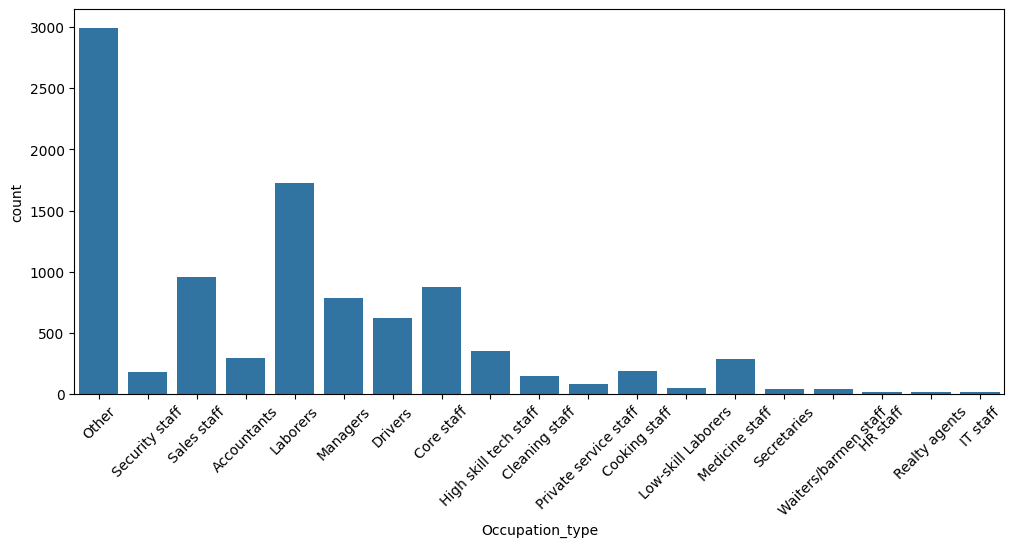

In [8]:
fig= plt.figure(figsize=(12, 5))

sns.countplot(x='Occupation_type', data=df)
# Rotate x-labels and do not show output except chart
_ = plt.xticks(rotation=45)

There isn't too much interesting from just the distributions of these categorical variables. The first four distributions do show distributions with a disproportionate amount of one type, with housing type in particular being incredibly heavily slanted. The Occupation_type distribution isn't particularly interesting at first glance, other than it isn't a distribution I might expect to have a median income of $112,500. This lends further credence to this not being US dollars.

Let's continue with a more in-depth analysis of some of the relationships

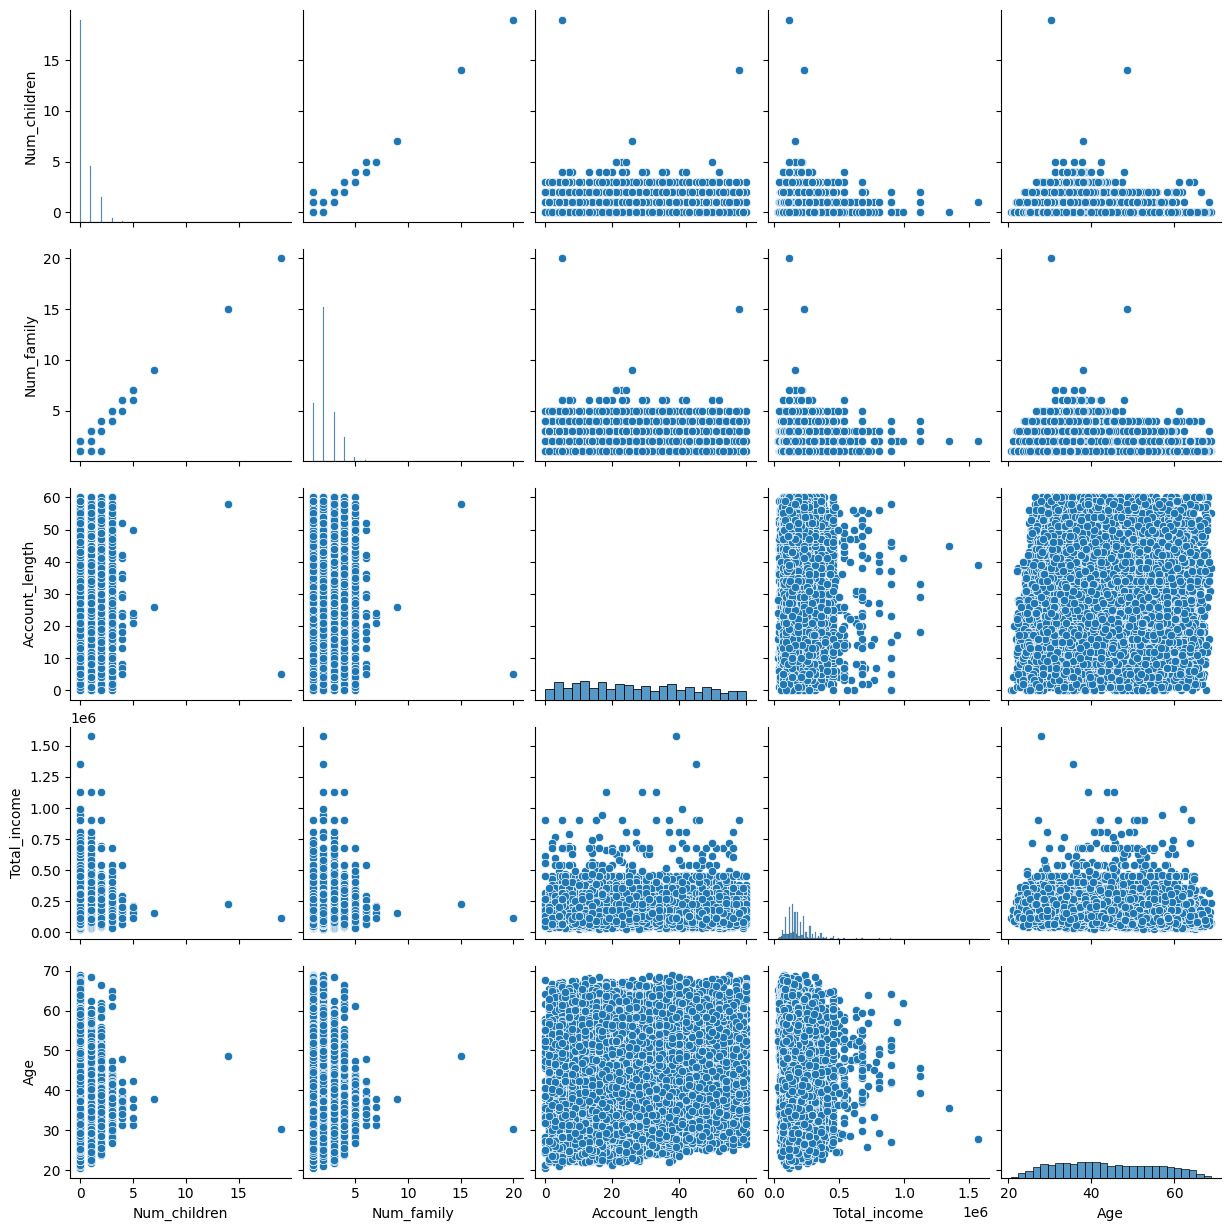

In [9]:
sns.pairplot(df[['Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age']])

There isn't too much that is terribly interesting here. There are some outliers in terms of number of children and number of family members (which are understandably highly correlated) and in terms of income. If I wasn't planning on using a tree based model, I might be more worried about this. The more interesting thing is that I am pretty sure I am seeing somebody with and account age of 60 with an age of 25 or 30. Is the Age in years and the account age in months? Since I am going to do it anyways, I'll go ahead and add a feature that is the difference.

In [10]:
df['Age_when_account_opened'] = df['Age'] - df['Account_length']

<Axes: xlabel='Age_when_account_opened', ylabel='Count'>

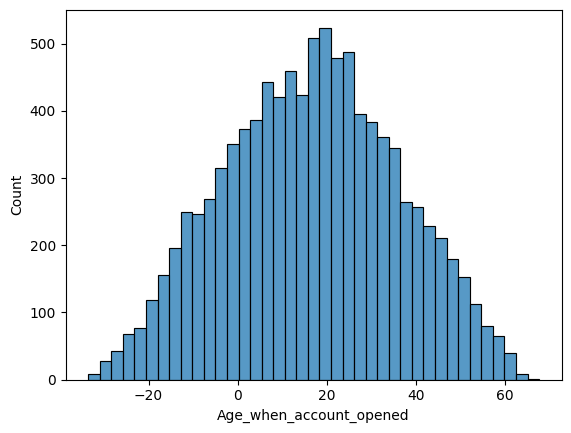

In [11]:
sns.histplot(df['Age_when_account_opened'])

<Axes: xlabel='Target', ylabel='Age_when_account_opened'>

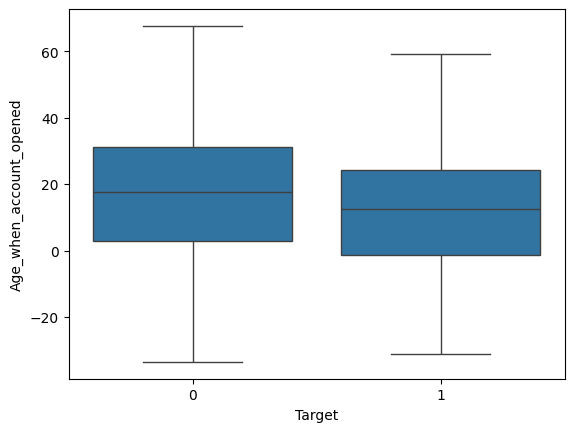

In [12]:
sns.boxplot(x='Target', y='Age_when_account_opened', data=df)

In [13]:
print(df.groupby('Target').agg({'Age_when_account_opened':'mean'}))
print(stats.ttest_ind(df[df['Target'] == 0]['Age_when_account_opened'], df[df['Target'] == 1]['Age_when_account_opened']))
print(df.loc[df['Age_when_account_opened']<=0,'Age_when_account_opened'].count())

        Age_when_account_opened
Target                         
0                     17.215447
1                     11.907565
TtestResult(statistic=9.147101931752307, pvalue=7.026284428515568e-20, df=9707.0)
2089


<Axes: xlabel='Age_when_account_opened', ylabel='Density'>

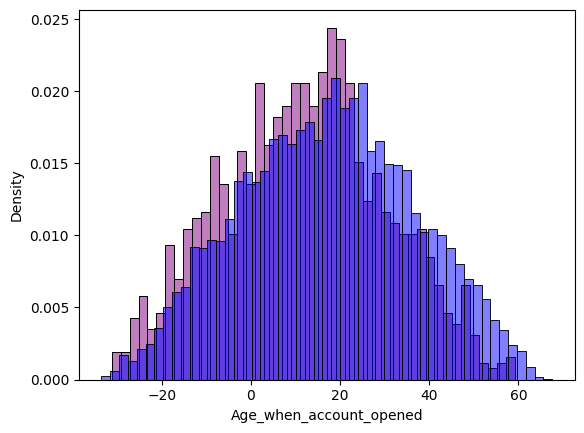

In [14]:
ax = plt.figure()
sns.histplot(df.loc[df['Target']==1,'Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=2, stat='density')
sns.histplot(df.loc[df['Target']==0,'Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=2, stat='density')

I struggle with what to make of this dataset at this point. There is a statitstically significant difference in the mean value, and the approved/rejected distributions look very similar, just shifted slightly. Let's see if this applies to other variables.

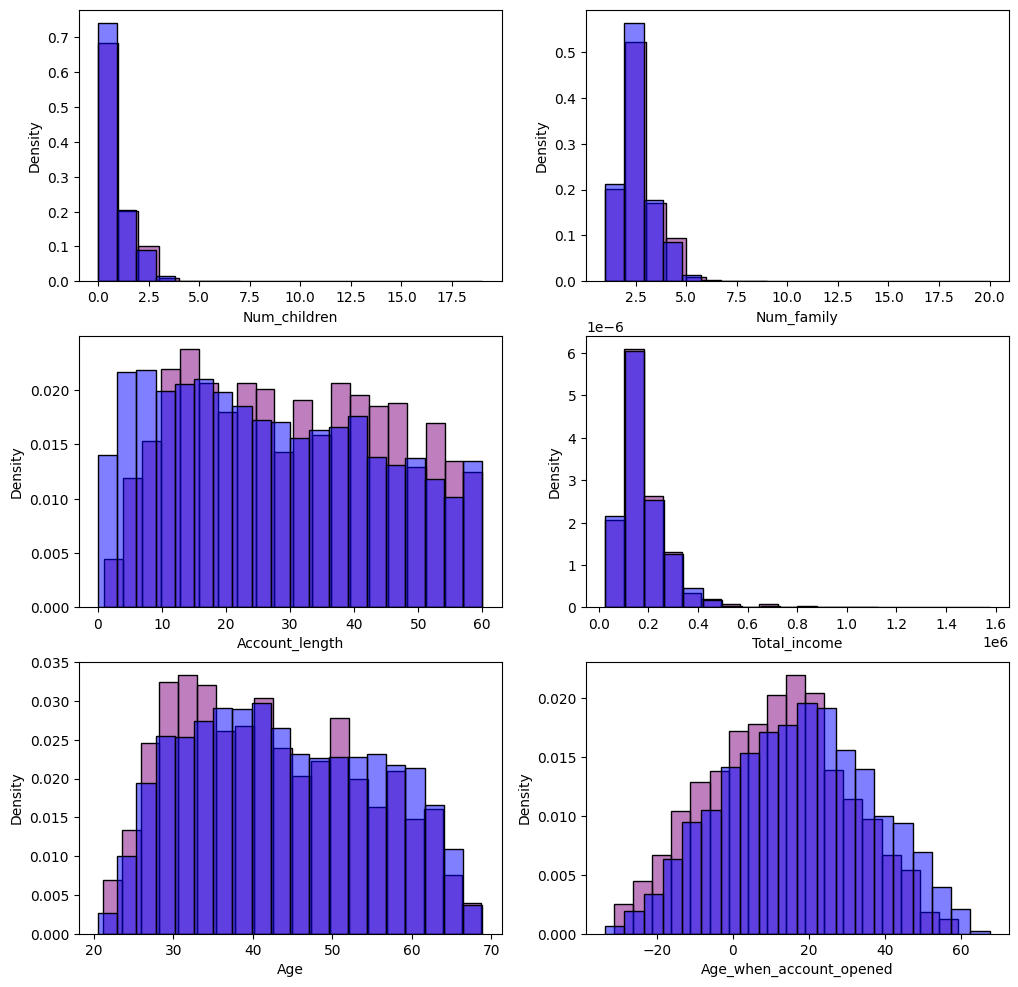

In [15]:
# Write code that creates a figure with six subplots in a 3x2 grid. Then iterate over the columns 'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', and 'Age_when_account_opened' and plot a histogram of each column in a different subplot. Use 40 bins for each histogram.
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
columns = ['Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 'Age_when_account_opened']
for i, col in enumerate(columns):
    #sns.histplot(df[col], bins=40, ax=ax[i//2, i%2])
    width = (df[col].max() - df[col].min())/20
    sns.histplot(df.loc[df['Target']==1,col], color = 'purple', alpha=0.5, binwidth=width, stat='density', ax=ax[i//2, i%2])
    sns.histplot(df.loc[df['Target']==0,col], color = 'blue', alpha=0.5, binwidth=width, stat='density', ax=ax[i//2, i%2])

In [16]:
for col in columns:
    print(f'{col} tests')
    print('Mann-Whitney U test: ', stats.mannwhitneyu(df.loc[df['Target'] == 0,col], df.loc[df['Target'] == 1, col]))
    print('Kolmogorov-Smirnov test: ', stats.ks_2samp(df.loc[df['Target'] == 0,col], df.loc[df['Target'] == 1, col]))

Num_children tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5288595.0, pvalue=0.12048112564848662)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.020745922643401016, pvalue=0.7149207500691063, statistic_location=0, statistic_sign=1)
Num_family tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5339332.5, pvalue=0.4401937623359963)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.013648416668223787, pvalue=0.9836567830726242, statistic_location=2, statistic_sign=1)
Account_length tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=4670131.0, pvalue=3.79931780783753e-15)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.0982565377291348, pvalue=8.243228820947575e-10, statistic_location=9, statistic_sign=1)
Total_income tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5337229.0, pvalue=0.4658587268217508)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.016376120455576855, pvalue=0.920847979233662, statistic_location=189000.0, statistic_sign=1)
Age te

So overall, we see three first-order differences in our continuous and ordinal variables. First, Age_when_account_opened has the aformentioned shift. Second, there is a slightly higher rate of acceptances for relatively young people and a higher rate of rejection for older people. Third, people with low account_length (<10) are more likely to be rejected. These differences, and the lack of differences in other distributions, are confirmed by both of our chosen statistical tests.

In particular, let's check if the difference in distribution for age_when_account_opened is controlled by the rejection for account age.

<Axes: xlabel='Age_when_account_opened', ylabel='Density'>

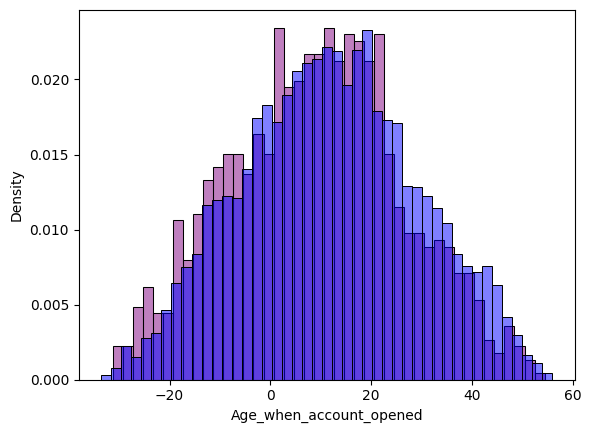

In [17]:
ax = plt.figure()
sns.histplot(df.loc[(df['Target']==1)&(df['Account_length']>10),'Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=2, stat='density')
sns.histplot(df.loc[(df['Target']==0)&(df['Account_length']>10),'Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=2, stat='density')

It is hard to tell precisely. It may have had some effect, but the difference between the distribution still remains. Let's continue to investigate with differences in the binary variables.

In [18]:
df[['Gender', 'Own_car', 'Own_property','Work_phone', 'Phone', 'Email', 'Unemployed','Target']].groupby('Target').mean()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed
Target,,,,,,,
0,0.345953,0.368977,0.676715,0.217897,0.289343,0.086755,0.178376
1,0.367108,0.359314,0.637568,0.214341,0.276695,0.092751,0.150429


In [19]:
columns = ['Gender', 'Own_car', 'Own_property','Work_phone', 'Phone', 'Email', 'Unemployed']
for col in columns:
    print(f'{col} ztest:')
    print(proportions_ztest([df.loc[df['Target']==1, col].sum(), df.loc[df['Target']==0, col].sum()], [df[col].sum(), df.shape[0]-df[col].sum()]))

Gender ztest:
(-31.719473903452723, 8.37356380896899e-221)
Own_car ztest:
(-37.177233706047936, 1.5922290131395636e-302)
Own_property ztest:
(-163.8192342839417, 0.0)
Work_phone ztest:
(-10.974008945035033, 5.09616085877792e-28)
Phone ztest:
(-22.210846749212973, 2.6980504587040522e-109)
Email ztest:
(5.664246103407427, 1.476723371138819e-08)
Unemployed ztest:
(-7.2691706352592185, 3.6170127753830766e-13)


So it's one of those situations where, due to the large sample size, every one of a binary variables is statistically different. But looking at the acutal differences, they are probably too small to be significantly meaningful. However, we will definitely all of these in our first pass modeling. Let's now move on to the non-binary categorical variables.

In [20]:
df.columns
columns = ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']
for col in columns:
    temp = df.groupby([col, 'Target']).agg({'ID':'count'}).reset_index()
    temp = temp.pivot(index='Target', columns=col, values='ID').reset_index().drop(columns=['Target'])
    # Drop a column if any of its values are less than 5
    temp = temp.loc[:,temp.columns[temp.min()>=5]]
    print(f'{col} Chi-Squared: ', stats.chi2_contingency(temp))
    

Income_type Chi-Squared:  Chi2ContingencyResult(statistic=2.4609572606540886, pvalue=0.48238831884302424, dof=3, expected_freq=array([[2006.62353184, 1485.87348032,  626.63589532, 4304.86709252],
       [ 305.37646816,  226.12651968,   95.36410468,  655.13290748]]))
Education_type Chi-Squared:  Chi2ContingencyResult(statistic=5.574135670268678, pvalue=0.13427111375208658, dof=3, expected_freq=array([[2132.62434299,  322.02019994,   98.94960322, 5868.40585386],
       [ 324.37565701,   48.97980006,   15.05039678,  892.59414614]]))
Family_status Chi-Squared:  Chi2ContingencyResult(statistic=8.26356038221152, pvalue=0.08238700372343694, dof=4, expected_freq=array([[ 725.52641879, 5667.09032856,  498.14852199, 1179.41435781,
         355.82037285],
       [ 110.47358121,  862.90967144,   75.85147801,  179.58564219,
          54.17962715]]))
Housing_type Chi-Squared:  Chi2ContingencyResult(statistic=4.828985606779703, pvalue=0.3052989429331711, dof=4, expected_freq=array([[7535.10904393,  2

Statistically, Family_status is bordering on significant, and education is also close. These variables may have some influence in our model. The other variables are questionable. I would still like to take a look at the occupation types, as with a high degree of freedom, there could be .

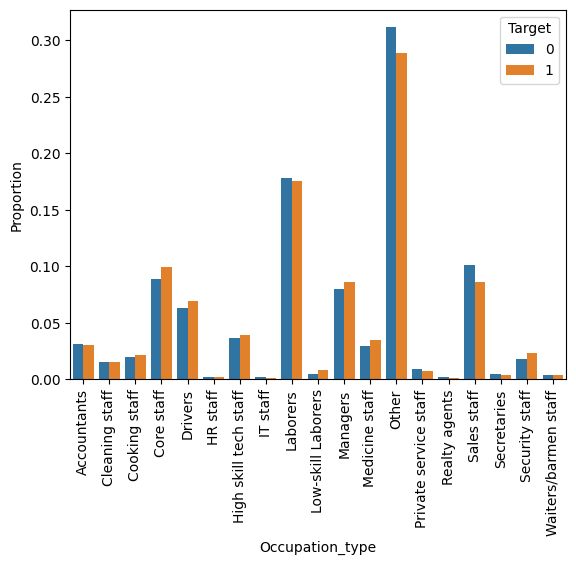

In [21]:
temp = df.groupby(['Occupation_type', 'Target']).agg({'ID':'count'}).reset_index()
# Convert the count in the ID column to a proportion of the total count for each target value
temp['ID'] = temp.groupby('Target')['ID'].transform(lambda x: x/x.sum())
temp = temp.rename(columns={'ID':'Proportion'})

sns.barplot(x='Occupation_type', y='Proportion', hue='Target', data=temp)
_ = plt.xticks(rotation=90)


Very little obvious difference. This concludes our examination of what is mostly the first_order interactions of variables the target variable. Next, we will look at some potential second order interactions and attempt further feature engineering.

The first thing I am interested in is something like total income divided by family members

In [22]:
df1 = df.copy()

In [23]:
df1['income_per_family_member'] = df1['Total_income'] / df1['Num_family']

Mann-Whitney U test:  MannwhitneyuResult(statistic=5399919.0, pvalue=0.9542622085668055)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.021514523117123093, pvalue=0.671949155098313, statistic_location=222750.0, statistic_sign=1)


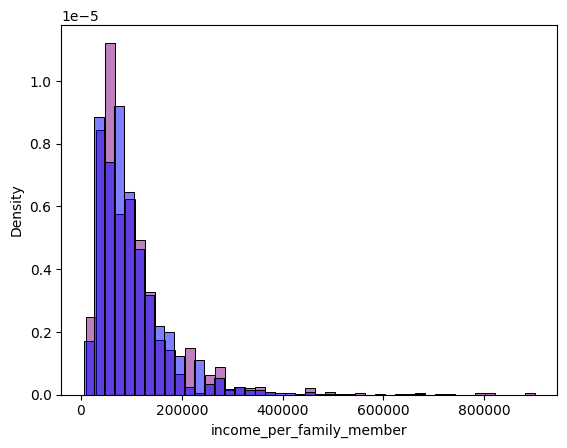

In [24]:
fig = plt.figure()
sns.histplot(df1.loc[(df1['Target']==1),'income_per_family_member'], color = 'purple', alpha=0.5, binwidth=20000, stat='density')
sns.histplot(df1.loc[(df1['Target']==0),'income_per_family_member'], color = 'blue', alpha=0.5, binwidth=20000, stat='density')
print('Mann-Whitney U test: ', stats.mannwhitneyu(df1.loc[df1['Target'] == 0,'income_per_family_member'], df1.loc[df1['Target'] == 1, 'income_per_family_member']))
print('Kolmogorov-Smirnov test: ', stats.ks_2samp(df1.loc[df1['Target'] == 0,'income_per_family_member'], df1.loc[df1['Target'] == 1, 'income_per_family_member']))


In [25]:
columns = ['Num_family', 'Account_length', 'Total_income', 'Age', 'Age_when_account_opened']
new_columns = []
temp = df.copy()
temp = temp.loc[temp['Num_family'] < 11,:]
for i in range(len(columns)):
    for j in range(i+1,len(columns)):

        c1 = columns[i]
        c2 = columns[j]
        temp[c1 + '_x_' + c2] = temp[c1] * temp[c2]
        temp[c1 + '_x_' + c2] = np.sqrt((temp[c1 + '_x_' + c2] - temp[c1 + '_x_' + c2].min()) / temp[c1 + '_x_' + c2].max())
        new_columns.append(c1 + '_x_' + c2)

temp = temp[new_columns + ['Target']]

for col in new_columns:
    print(f'{col} tests')
    print('Mann-Whitney U test: ', stats.mannwhitneyu(temp.loc[temp['Target'] == 0,col], temp.loc[temp['Target'] == 1, col]))
    print('Kolmogorov-Smirnov test: ', stats.ks_2samp(temp.loc[temp['Target'] == 0,col], temp.loc[temp['Target'] == 1, col]))

Num_family_x_Account_length tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=4739650.0, pvalue=1.201076704066188e-12)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.09329170487913019, pvalue=6.932905030958785e-09, statistic_location=0.35805743701971643, statistic_sign=1)
Num_family_x_Total_income tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5292262.5, pvalue=0.23173733411576103)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.02880942176863195, pvalue=0.30720706829868333, statistic_location=0.19364916731037085, statistic_sign=1)
Num_family_x_Age tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=5584137.0, pvalue=0.05404441483520045)
Kolmogorov-Smirnov test:  KstestResult(statistic=0.04515491869350014, pvalue=0.02061029979009328, statistic_location=0.4378840076468942, statistic_sign=-1)
Num_family_x_Age_when_account_opened tests
Mann-Whitney U test:  MannwhitneyuResult(statistic=6160481.0, pvalue=5.96214555813577e-16)
Kolmogorov-Smirnov test:  KstestRes

<Axes: xlabel='Total_income_x_Age_when_account_opened', ylabel='Density'>

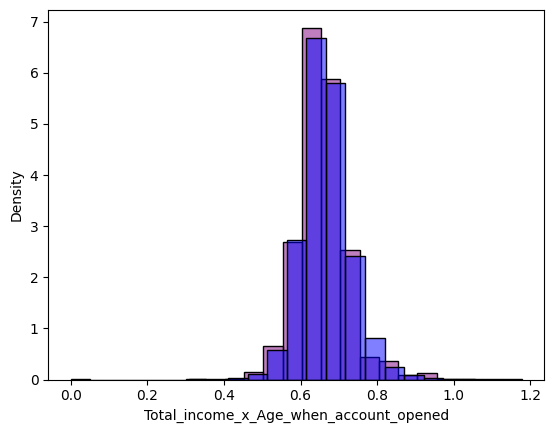

In [26]:
ax = plt.figure()
sns.histplot(temp.loc[(temp['Target']==1),'Total_income_x_Age_when_account_opened'], color = 'purple', alpha=0.5, binwidth=0.05, stat='density')
sns.histplot(temp.loc[(temp['Target']==0),'Total_income_x_Age_when_account_opened'], color = 'blue', alpha=0.5, binwidth=0.05, stat='density')

So, what we see at this point, we are not seeing meaningful interaction between our between our variables. We could potentially continue evaluating like this using different functions and combinations. However, but at this point, with no obvious features to engineering, we may want to just turn to the machine learning model and see if we can refine features based on interactions that we see there. Let's start with the classic tree, going ahead and splitting a test set.

In [27]:
df2 = pd.get_dummies(df, drop_first=True)

for col in df2.columns:
    if df2[col].dtype == 'bool':
        df2[col] = df2[col].astype(int)

In [28]:
X = df2.drop(columns=['ID', 'Target'])
y = df2[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
clf = cat.CatBoostClassifier(iterations=250, learning_rate=0.01, depth=8, verbose=100, random_state=42)

cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

print(cv)

0:	learn: 0.6859468	total: 48.8ms	remaining: 12.1s
100:	learn: 0.4089830	total: 194ms	remaining: 285ms
200:	learn: 0.3698787	total: 345ms	remaining: 84.1ms
249:	learn: 0.3603492	total: 419ms	remaining: 0us
0:	learn: 0.6859702	total: 2.19ms	remaining: 546ms
100:	learn: 0.4083790	total: 147ms	remaining: 217ms


200:	learn: 0.3678791	total: 316ms	remaining: 77.1ms
249:	learn: 0.3589459	total: 406ms	remaining: 0us
0:	learn: 0.6860016	total: 3.72ms	remaining: 927ms
100:	learn: 0.4084169	total: 187ms	remaining: 276ms
200:	learn: 0.3690950	total: 333ms	remaining: 81.1ms
249:	learn: 0.3601622	total: 406ms	remaining: 0us
0:	learn: 0.6859261	total: 2.99ms	remaining: 745ms
100:	learn: 0.4086711	total: 156ms	remaining: 231ms
200:	learn: 0.3688576	total: 301ms	remaining: 73.5ms
249:	learn: 0.3602191	total: 375ms	remaining: 0us
0:	learn: 0.6859264	total: 2.75ms	remaining: 685ms
100:	learn: 0.4090244	total: 185ms	remaining: 273ms
200:	learn: 0.3692244	total: 334ms	remaining: 81.4ms
249:	learn: 0.3613551	total: 405ms	remaining: 0us
[0.59310058 0.6055105  0.59126077 0.58156619 0.59077224]


This is both interesting and unfortunate. Our model appears to be very weak, indicating that there is not strong information contained in this data set. Let's see what we can find from analyzing a produced model

In [30]:
clf.fit(X_train, y_train)

clf.get_feature_importance(prettified=True)

0:	learn: 0.6859824	total: 2.52ms	remaining: 628ms
100:	learn: 0.4092291	total: 164ms	remaining: 243ms
200:	learn: 0.3717434	total: 323ms	remaining: 78.8ms
249:	learn: 0.3634860	total: 403ms	remaining: 0us


,Feature Id,Importances
0,Account_length,13.823311
1,Age_when_account_opened,11.011251
2,Years_employed,8.757004
3,Total_income,7.577813
4,Age,7.358045
5,Num_family,5.617042
6,Num_children,4.550825
7,Family_status_Single / not married,3.580007
8,Own_property,3.383633
9,Own_car,3.117932


In [31]:
X_train.dtypes

Gender                                            int64
Own_car                                           int64
Own_property                                      int64
Work_phone                                        int64
Phone                                             int64
Email                                             int64
Unemployed                                        int64
Num_children                                      int64
Num_family                                        int64
Account_length                                    int64
Total_income                                    float64
Age                                             float64
Years_employed                                  float64
Age_when_account_opened                         float64
Income_type_Pensioner                             int64
Income_type_State servant                         int64
Income_type_Student                               int64
Income_type_Working                             

In [32]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

100%|===================| 7737/7767 [01:17<00:00]        

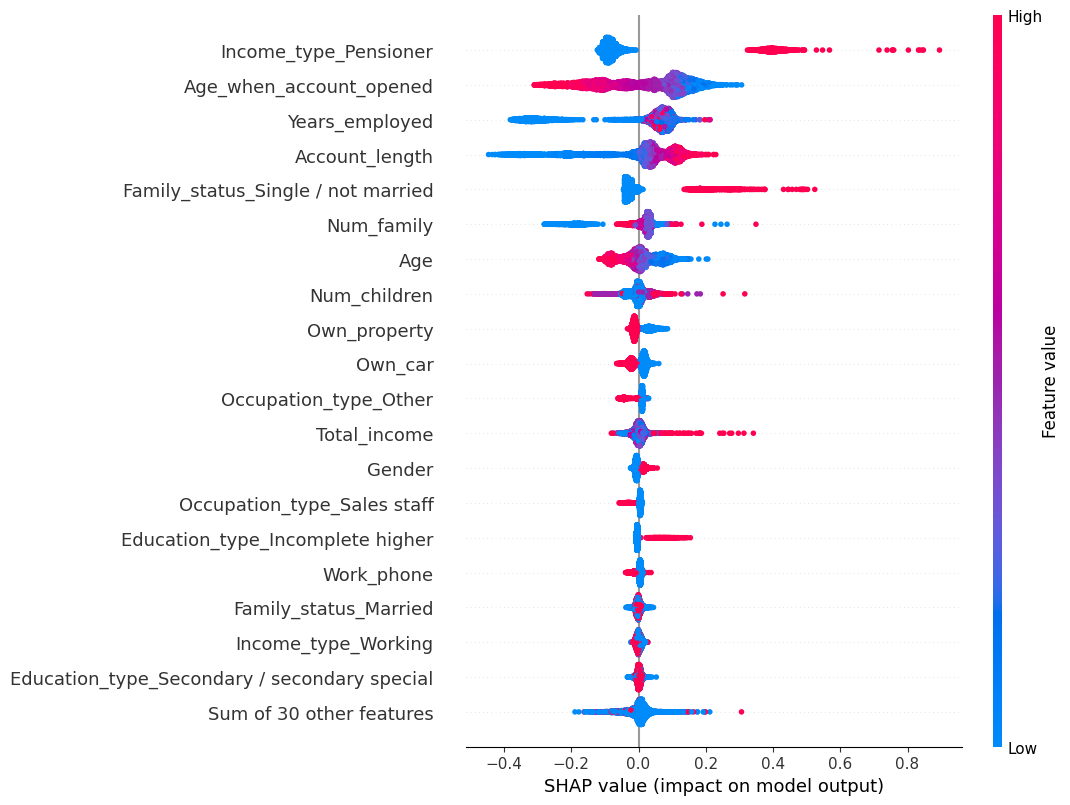

In [33]:
type(shap_values)
shap.plots.beeswarm(shap_values, max_display=20)

In [34]:
explainer = shap.Explainer(clf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)



In [35]:
shap_interaction_values[0].shape

vals = []
inds = []
for i in range(0,shap_interaction_values[0].shape[0]):
    for j in range(i,shap_interaction_values[0].shape[1]):
        #print(i)
        vals.append(abs(shap_interaction_values[0][i, j]))
        inds.append((i, j))

a = pd.DataFrame({'vals':vals, 'inds':inds}).sort_values('vals', ascending=False)
a.head(20)

,vals,inds
595,0.410609,"(14, 14)"
559,0.214231,"(13, 13)"
524,0.150679,"(12, 14)"
405,0.121635,"(9, 9)"
484,0.059616,"(11, 11)"
364,0.035915,"(8, 8)"
97,0.029206,"(2, 2)"
623,0.027528,"(14, 42)"
522,0.022182,"(12, 12)"
487,0.018102,"(11, 14)"


<Axes: >

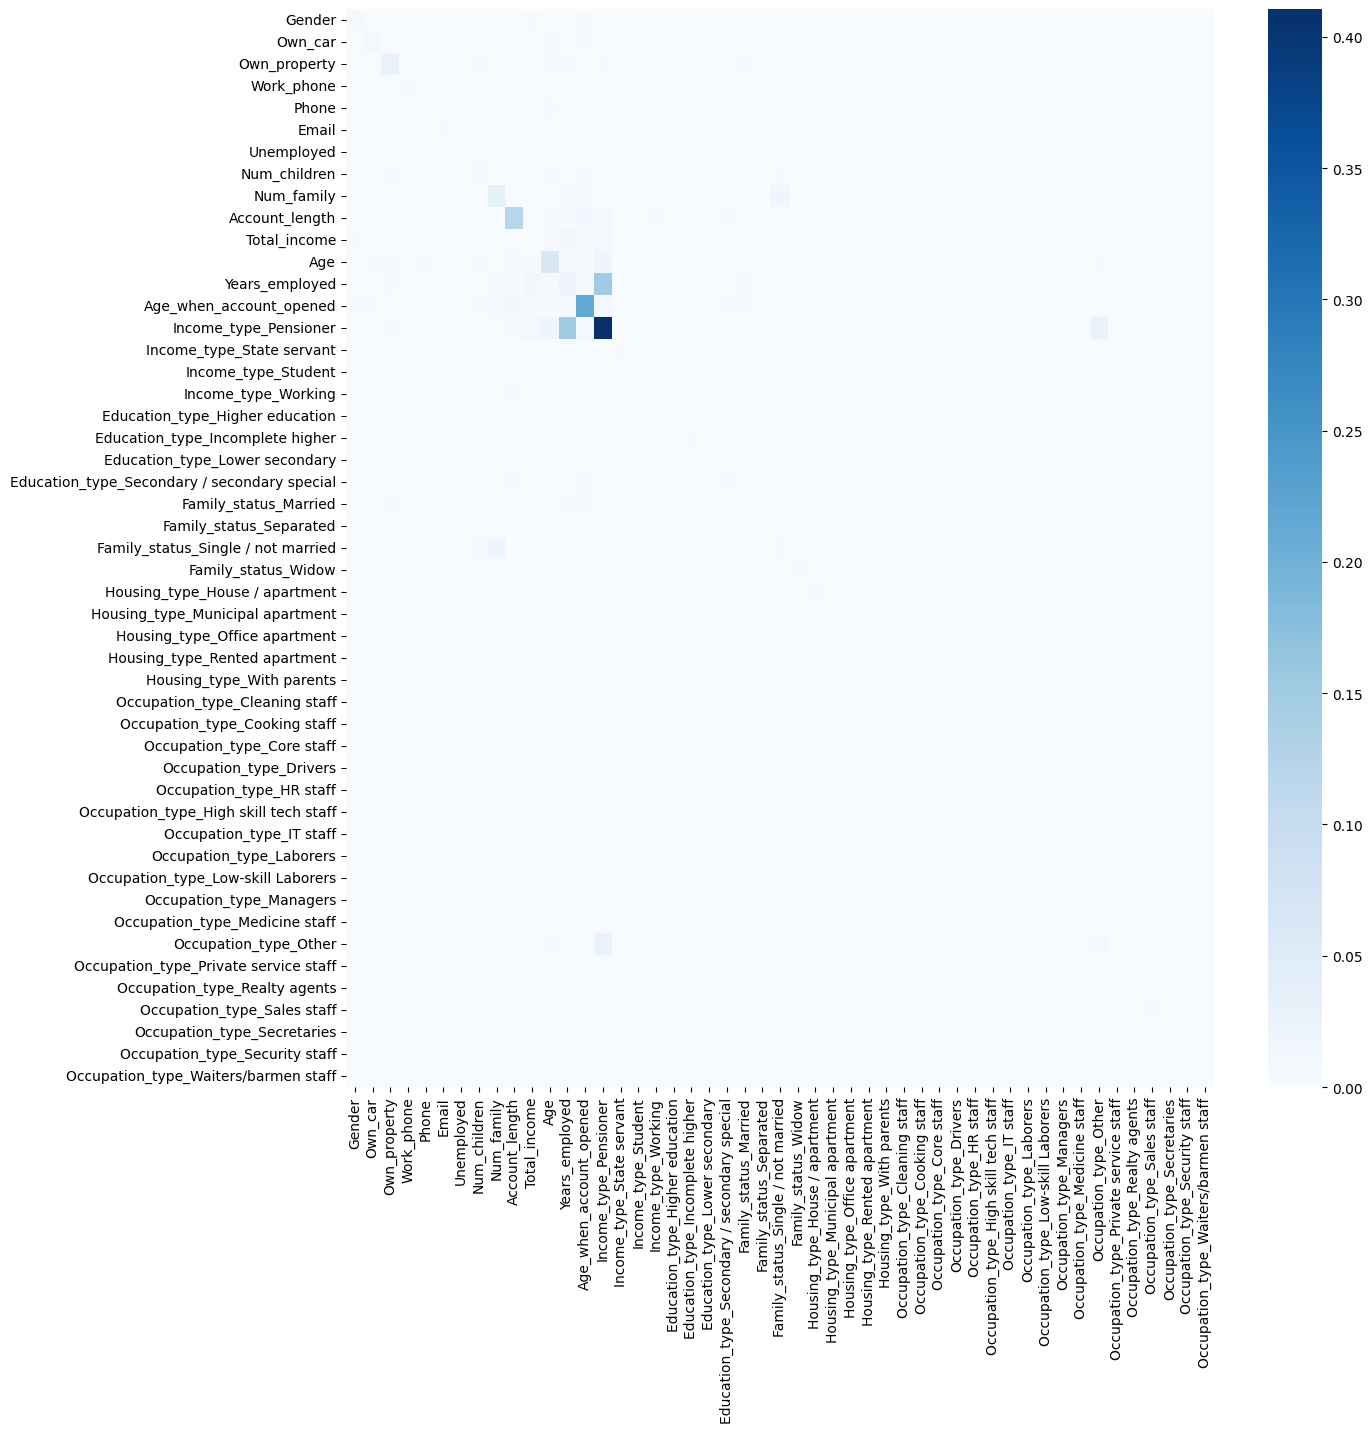

In [36]:
siv = np.abs(shap_interaction_values[0])

plt.figure(figsize=(14, 14))
sns.heatmap(siv, cmap='Blues', xticklabels=clf.feature_names_, yticklabels=clf.feature_names_)

With this, we have a much more intricate work around around interactions in our work. While this does not tell us the form of any of the interactions, it does give us a place to start and a relative indication of how important interactions are relative to the effects of individual variables.

The first thing I notice is that is that income type is our dominant predictive variable, and it has one of our few strong interactive effects. We did not see a strong first order effect in our EDA, reproduced below.

            Income_type  Target    ID
0  Commercial associate       0  1998
1  Commercial associate       1   314
2             Pensioner       0  1503
3             Pensioner       1   209
4         State servant       0   632
5         State servant       1    90
6               Student       0     2
7               Student       1     1
8               Working       0  4291
9               Working       1   669


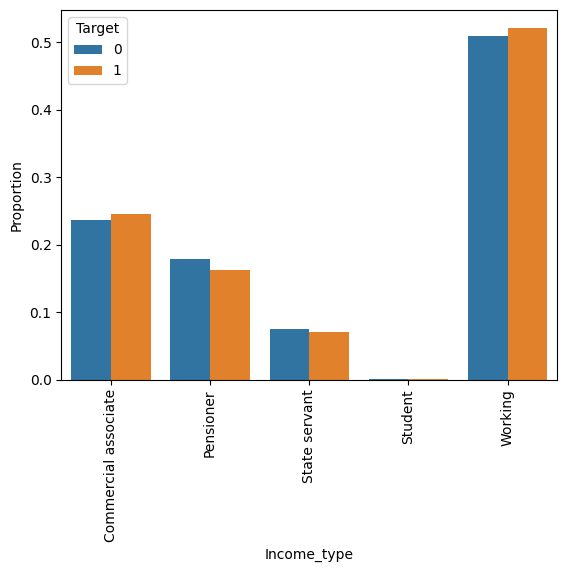

In [37]:
temp = df.groupby(['Income_type', 'Target']).agg({'ID':'count'}).reset_index()
print(temp)
# Convert the count in the ID column to a proportion of the total count for each target value
temp['ID'] = temp.groupby('Target')['ID'].transform(lambda x: x/x.sum())
temp = temp.rename(columns={'ID':'Proportion'})

sns.barplot(x='Income_type', y='Proportion', hue='Target', data=temp)
_ = plt.xticks(rotation=90)


Now, what let's take a look at interactions

<Axes: xlabel='Income_type', ylabel='Years_employed'>

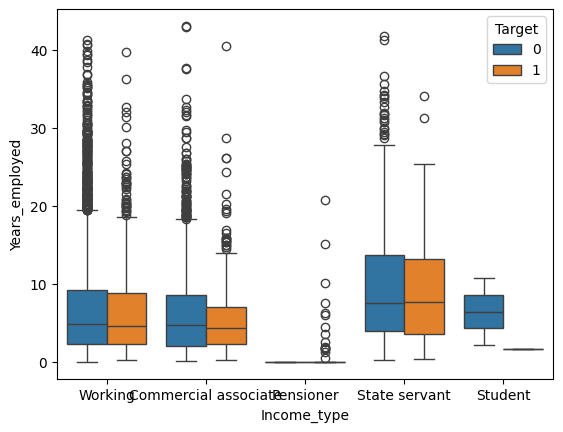

In [38]:
sns.boxplot(x='Income_type', y='Years_employed', hue='Target', data=df)

In [39]:
temp = df.loc[df['Income_type'] == 'Pensioner',:]

print(pd.unique(temp.loc[temp['Target']==1,'Years_employed']))
print(pd.unique(temp.loc[temp['Target']==0,'Years_employed']))
temp.loc[temp['Target']==1,'Years_employed'].value_counts()

[ 0.          1.60441351  1.85630095  2.4997091   4.50111912  6.04529867
  6.212311   10.07549779  1.2128928   1.84261142  1.83987351  1.69750234
 20.67941162  7.51555473 15.11598459  0.54210559  3.62772678]
[0.]


Years_employed
0.000000     193
1.842611       1
0.542106       1
15.115985      1
7.515555       1
20.679412      1
1.697502       1
1.839874       1
1.212893       1
1.604414       1
10.075498      1
6.212311       1
6.045299       1
4.501119       1
2.499709       1
1.856301       1
3.627727       1
Name: count, dtype: int64

So, this is disappointing to say the least. It appears that having any years working and being a pensioner basically guarantees approval, but this only applies to 16 people out of a data set of 9000. Hopefully, we can engineer a feature that demonstrates this and then reperform the procedure to get better insights.

In [40]:
df['pensioner_with_work'] = ((df['Income_type'] == 'Pensioner') & (df['Years_employed'] > 0)).astype(int)

In [41]:
df2 = pd.get_dummies(df, drop_first=True)

for col in df2.columns:
    if df2[col].dtype == 'bool':
        df2[col] = df2[col].astype(int)

X = df2.drop(columns=['ID', 'Target'])
y = df2[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = cat.CatBoostClassifier(iterations=300, learning_rate=0.01, depth=8, verbose=100, random_state=42)

cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

print(cv)

0:	learn: 0.6858897	total: 2.09ms	remaining: 625ms
100:	learn: 0.4079585	total: 154ms	remaining: 303ms
200:	learn: 0.3685308	total: 308ms	remaining: 152ms


299:	learn: 0.3536286	total: 500ms	remaining: 0us
0:	learn: 0.6859210	total: 3.95ms	remaining: 1.18s
100:	learn: 0.4084090	total: 170ms	remaining: 335ms
200:	learn: 0.3695694	total: 320ms	remaining: 158ms
299:	learn: 0.3542292	total: 472ms	remaining: 0us
0:	learn: 0.6858681	total: 5.38ms	remaining: 1.61s
100:	learn: 0.4077133	total: 184ms	remaining: 362ms
200:	learn: 0.3704284	total: 330ms	remaining: 162ms
299:	learn: 0.3555100	total: 478ms	remaining: 0us
0:	learn: 0.6857996	total: 4.05ms	remaining: 1.21s
100:	learn: 0.4080529	total: 192ms	remaining: 378ms
200:	learn: 0.3699920	total: 341ms	remaining: 168ms
299:	learn: 0.3549875	total: 495ms	remaining: 0us
0:	learn: 0.6858563	total: 5.29ms	remaining: 1.58s
100:	learn: 0.4090641	total: 180ms	remaining: 354ms
200:	learn: 0.3710858	total: 324ms	remaining: 159ms
299:	learn: 0.3559375	total: 476ms	remaining: 0us
[0.58825508 0.60542407 0.5876746  0.57780633 0.59155026]


In [42]:
clf.fit(X_train, y_train)

clf.get_feature_importance(prettified=True)

0:	learn: 0.6859123	total: 4.37ms	remaining: 1.3s


100:	learn: 0.4097935	total: 199ms	remaining: 392ms
200:	learn: 0.3721057	total: 361ms	remaining: 178ms
299:	learn: 0.3591914	total: 523ms	remaining: 0us


,Feature Id,Importances
0,Account_length,15.970658
1,Age_when_account_opened,10.533508
2,Years_employed,7.668958
3,Total_income,7.489159
4,Age,7.163561
5,Num_family,6.706783
6,Num_children,4.808824
7,Family_status_Single / not married,4.108700
8,Own_car,2.578722
9,Education_type_Secondary / secondary special,2.074604


In [43]:
explainer2 = shap.Explainer(clf, X_train)
shap_values2 = explainer2(X_train)

100%|===================| 7736/7767 [01:29<00:00]        

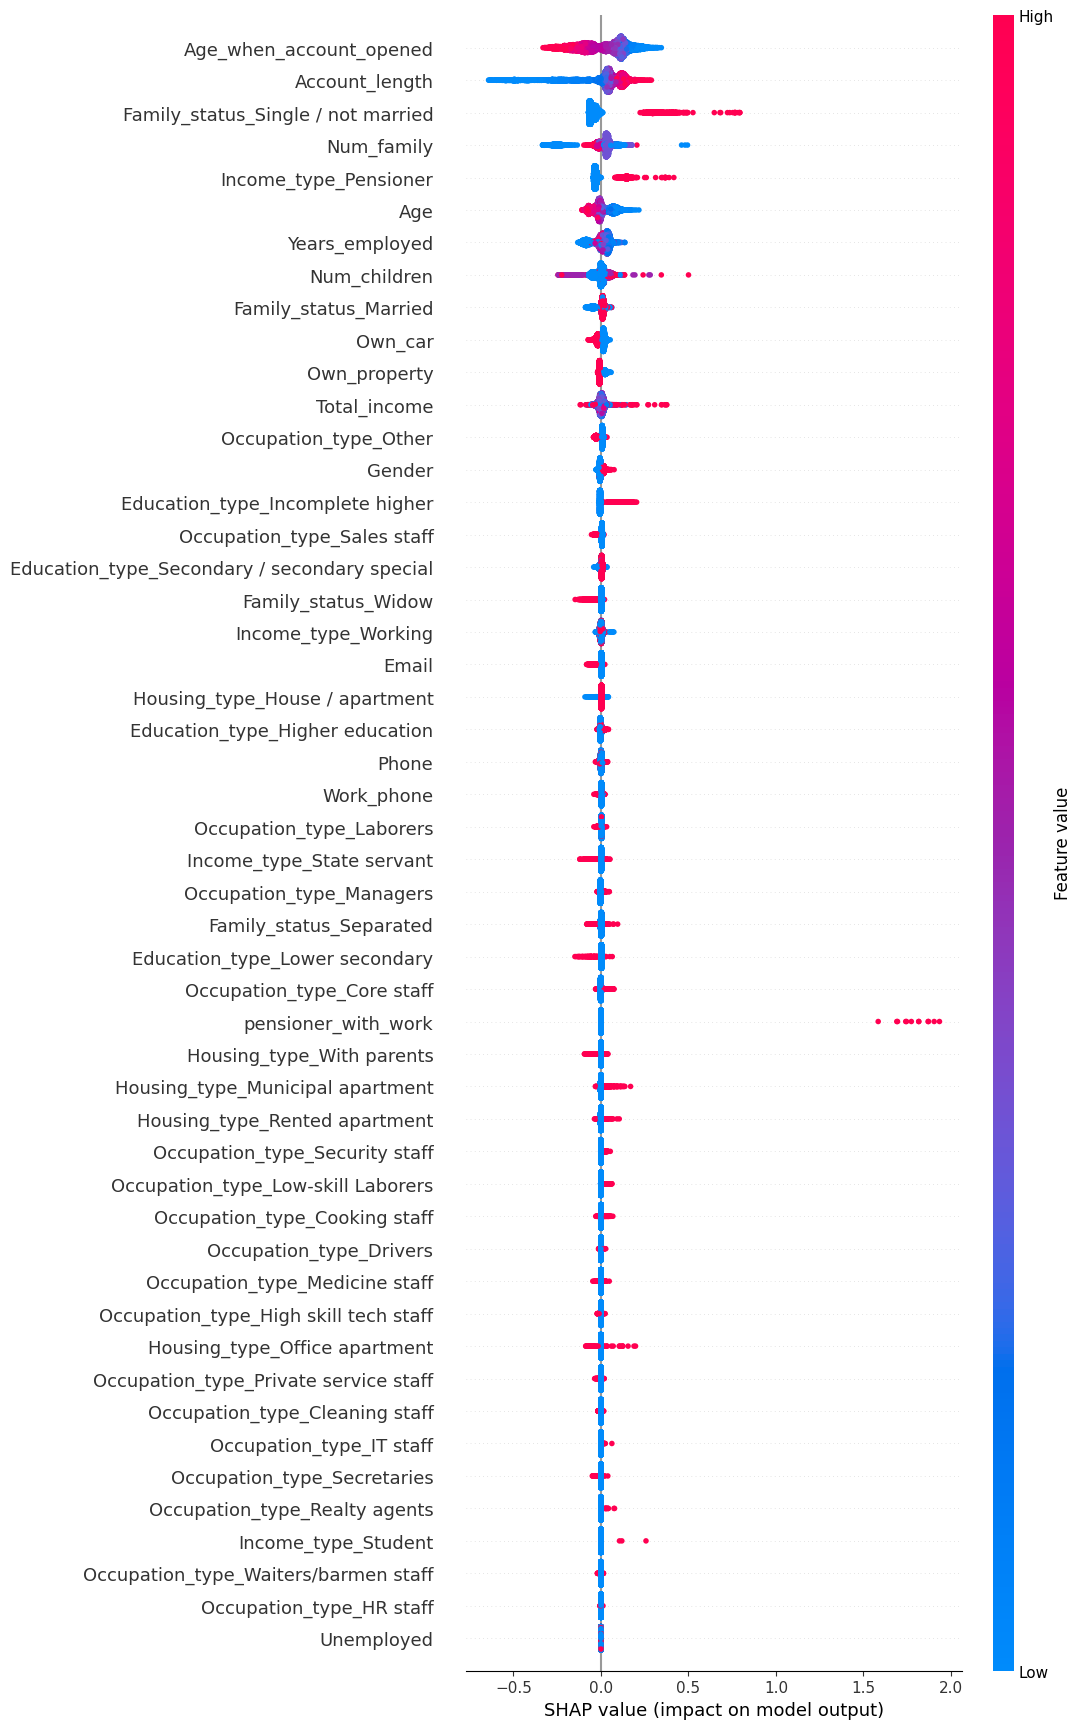

In [44]:
type(shap_values2)
shap.plots.beeswarm(shap_values2, max_display=50)

In [45]:
explainer = shap.Explainer(clf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

<Axes: >

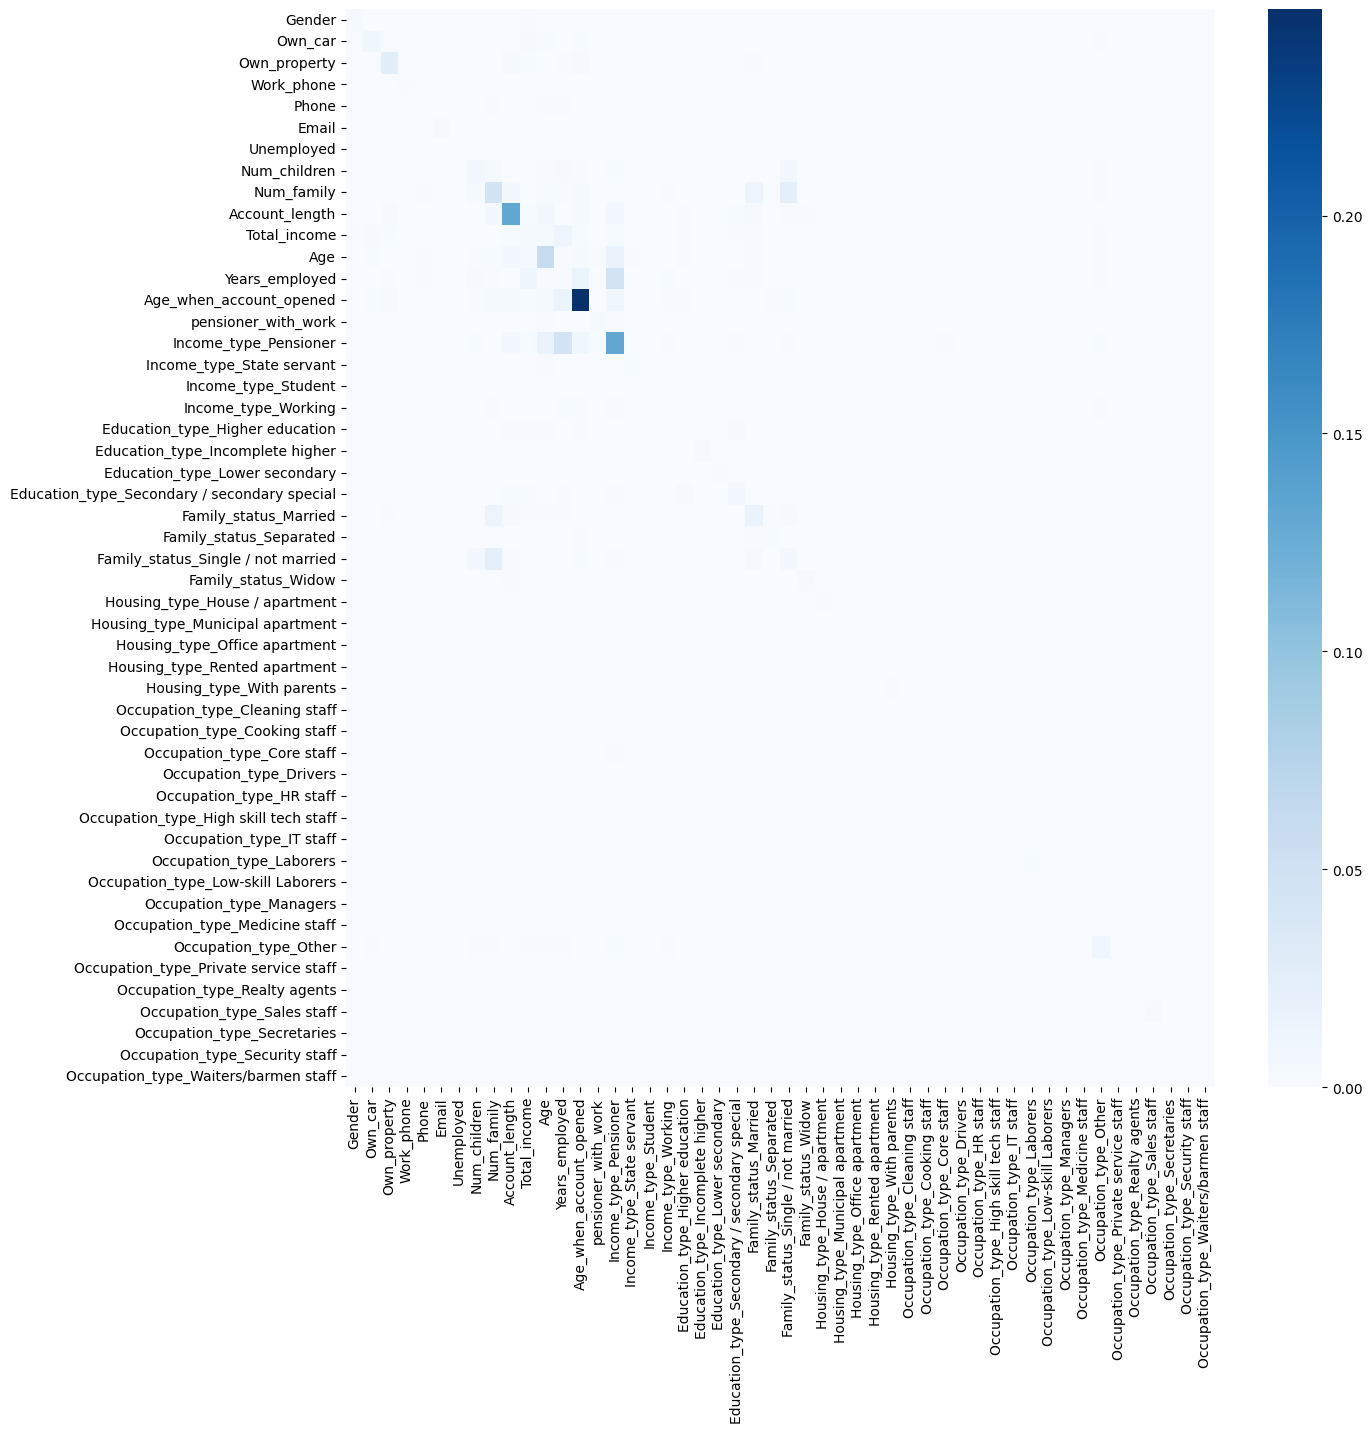

In [46]:
siv = np.abs(shap_interaction_values[0])

plt.figure(figsize=(14, 14))
sns.heatmap(siv, cmap='Blues', xticklabels=clf.feature_names_, yticklabels=clf.feature_names_)

Creating the pensioner with work feature has signficantly reduced the importance of the both the income_type_pensioner and years_employed/income_type_pensioner interaction. Interestingly, this did decrease the model score slightly, but with what appears to be a clear pattern and an understanding of the underlying mechanisms, we will accept it for now. We are now going to examine our next interaction feature, Family_status_single/Not_married and num_family

<Axes: xlabel='Family_status_Single / not married', ylabel='Num_family'>

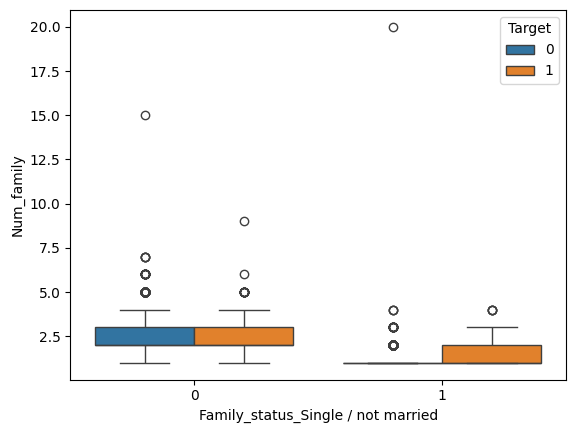

In [47]:
sns.boxplot(x='Family_status_Single / not married', y='Num_family', hue='Target', data=df2)

<Axes: xlabel='Num_family', ylabel='Density'>

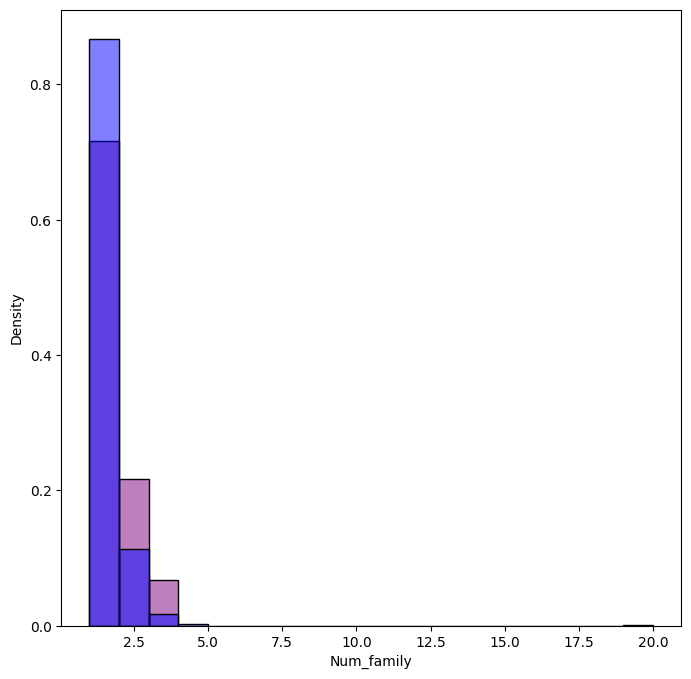

In [48]:
fig = plt.figure(figsize=(8, 8))
sns.histplot(df2.loc[(df2['Target']==1)&(df2['Family_status_Single / not married']==1),'Num_family'], color = 'purple', alpha=0.5, binwidth=1, stat='density')
sns.histplot(df2.loc[(df2['Target']==0)&(df2['Family_status_Single / not married']==1),'Num_family'], color = 'blue', alpha=0.5, binwidth=1, stat='density')

In [49]:
print(df2.loc[(df2['Target']==1)&(df2['Family_status_Single / not married']==1),'Num_family'].value_counts().T)
print(df2.loc[(df2['Target']==0)&(df2['Family_status_Single / not married']==1),'Num_family'].value_counts().T)

Num_family
1    149
2     45
3     10
4      4
Name: count, dtype: int64
Num_family
1     998
2     130
3      19
4       3
20      1
Name: count, dtype: int64


<Axes: xlabel='Num_family', ylabel='Density'>

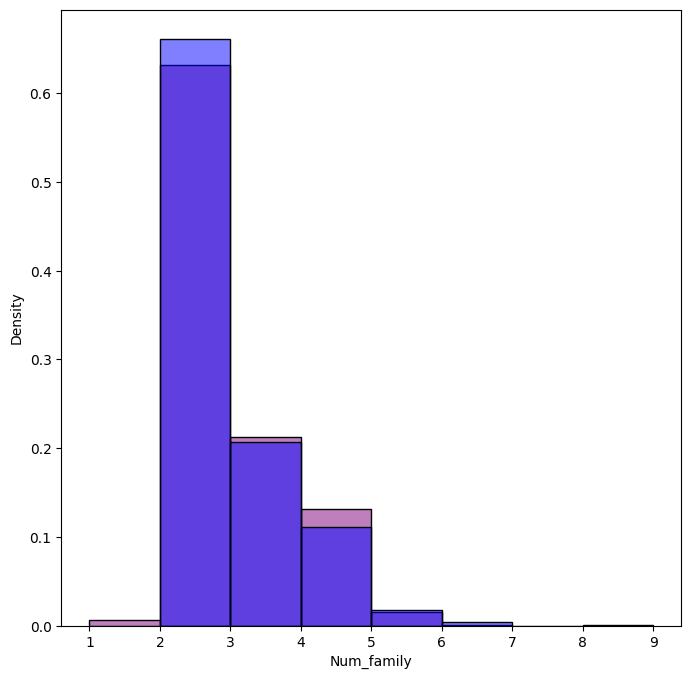

In [50]:
fig = plt.figure(figsize=(8, 8))
sns.histplot(df2.loc[(df2['Target']==1)&(df2['Family_status_Married']==1),'Num_family'], color = 'purple', alpha=0.5, binwidth=1, stat='density')
sns.histplot(df2.loc[(df2['Target']==0)&(df2['Family_status_Married']==1),'Num_family'], color = 'blue', alpha=0.5, binwidth=1, stat='density')

For those who are single or unmarried, there is a clear effect size showing that having some family members (I am assuming havine num_family==1 means just that person) increases acceptance rates. There is a much weaker pattern among married people, and I am not going to create that feature at this time

In [51]:
df['Single_with_family'] = ((df['Family_status'] == 'Single / not married') & (df['Num_family'] > 1)).astype(int)

In [52]:
df2 = pd.get_dummies(df, drop_first=True)

for col in df2.columns:
    if df2[col].dtype == 'bool':
        df2[col] = df2[col].astype(int)

X = df2.drop(columns=['ID', 'Target'])
y = df2[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = cat.CatBoostClassifier(iterations=300, learning_rate=0.01, depth=8, verbose=100, random_state=42)

cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

print(cv)

0:	learn: 0.6859905	total: 2.62ms	remaining: 784ms
100:	learn: 0.4076054	total: 198ms	remaining: 391ms


200:	learn: 0.3699120	total: 439ms	remaining: 216ms
299:	learn: 0.3558223	total: 635ms	remaining: 0us
0:	learn: 0.6858912	total: 4.24ms	remaining: 1.27s
100:	learn: 0.4067032	total: 227ms	remaining: 447ms
200:	learn: 0.3680979	total: 414ms	remaining: 204ms
299:	learn: 0.3538040	total: 610ms	remaining: 0us
0:	learn: 0.6860118	total: 4.71ms	remaining: 1.41s
100:	learn: 0.4082289	total: 208ms	remaining: 410ms
200:	learn: 0.3692352	total: 401ms	remaining: 198ms
299:	learn: 0.3544323	total: 602ms	remaining: 0us
0:	learn: 0.6859694	total: 4.03ms	remaining: 1.21s
100:	learn: 0.4069776	total: 225ms	remaining: 443ms
200:	learn: 0.3682096	total: 416ms	remaining: 205ms
299:	learn: 0.3539626	total: 612ms	remaining: 0us
0:	learn: 0.6859537	total: 4.52ms	remaining: 1.35s
100:	learn: 0.4079270	total: 230ms	remaining: 454ms
200:	learn: 0.3697918	total: 424ms	remaining: 209ms
299:	learn: 0.3553659	total: 619ms	remaining: 0us
[0.58701839 0.60853548 0.59613881 0.58012955 0.59520156]


In [53]:
clf.fit(X_train, y_train)

clf.get_feature_importance(prettified=True)

0:	learn: 0.6860539	total: 3.89ms	remaining: 1.16s
100:	learn: 0.4087673	total: 205ms	remaining: 405ms
200:	learn: 0.3717763	total: 409ms	remaining: 201ms
299:	learn: 0.3592641	total: 621ms	remaining: 0us


,Feature Id,Importances
0,Account_length,15.659462
1,Age_when_account_opened,10.741185
2,Years_employed,8.409392
3,Age,7.984090
4,Total_income,6.764387
5,Num_children,5.239286
6,Num_family,4.668177
7,Single_with_family,3.919911
8,Income_type_Working,3.234119
9,Own_car,2.599928


 99%|===================| 7683/7767 [01:28<00:00]        

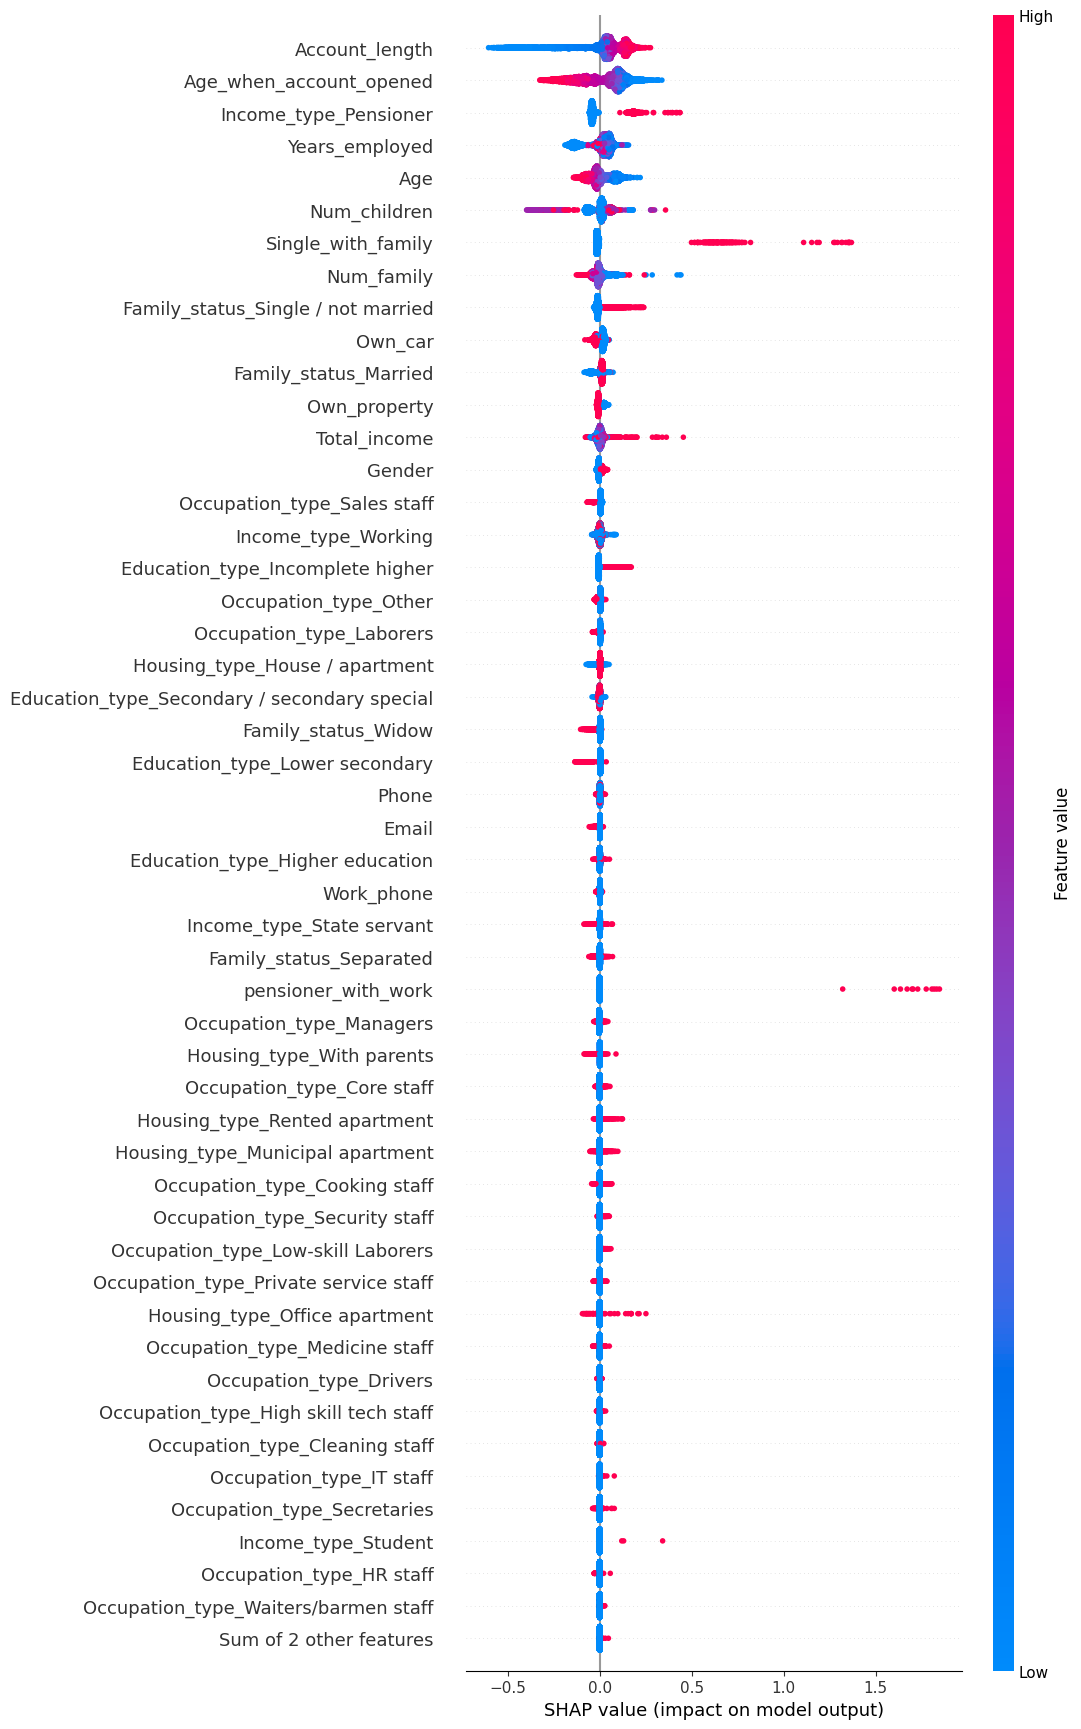

In [54]:
explainer3 = shap.Explainer(clf, X_train)
shap_values3 = explainer3(X_train)
shap.plots.beeswarm(shap_values3, max_display=50)

<Axes: >

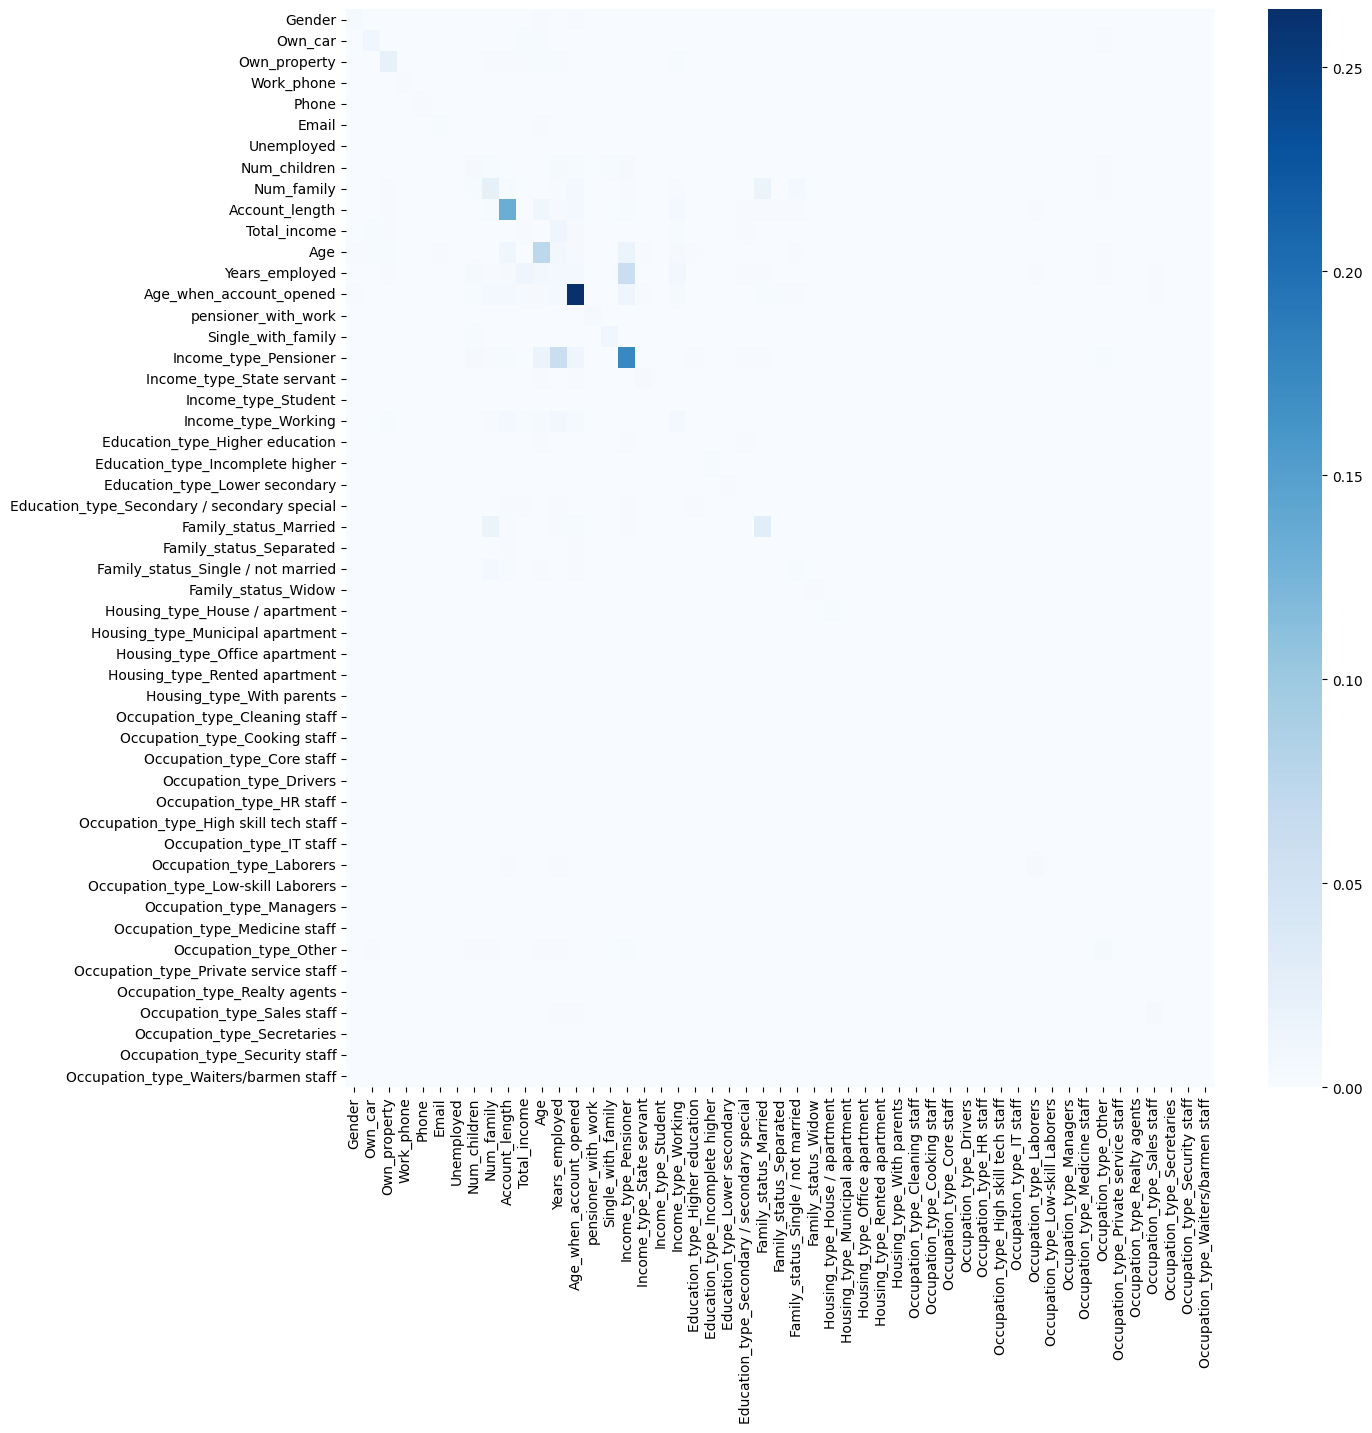

In [55]:
explainer = shap.Explainer(clf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

siv = np.abs(shap_interaction_values[0])

plt.figure(figsize=(14, 14))
sns.heatmap(siv, cmap='Blues', xticklabels=clf.feature_names_, yticklabels=clf.feature_names_)

In [56]:
# iterate through the upper triangle of the shap interaction values and find the top 20 interactions
vals = []
inds = []
print(clf.feature_names_)
for i in range(0,shap_interaction_values[0].shape[0]):
    for j in range(i,shap_interaction_values[0].shape[1]):
        #print(i)
        vals.append(abs(shap_interaction_values[0][i, j]))
        inds.append((clf.feature_names_[i], clf.feature_names_[j]))

a = pd.DataFrame({'vals':vals, 'inds':inds}).sort_values('vals', ascending=False)
a.head(20)


['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 'Years_employed', 'Age_when_account_opened', 'pensioner_with_work', 'Single_with_family', 'Income_type_Pensioner', 'Income_type_State servant', 'Income_type_Student', 'Income_type_Working', 'Education_type_Higher education', 'Education_type_Incomplete higher', 'Education_type_Lower secondary', 'Education_type_Secondary / secondary special', 'Family_status_Married', 'Family_status_Separated', 'Family_status_Single / not married', 'Family_status_Widow', 'Housing_type_House / apartment', 'Housing_type_Municipal apartment', 'Housing_type_Office apartment', 'Housing_type_Rented apartment', 'Housing_type_With parents', 'Occupation_type_Cleaning staff', 'Occupation_type_Cooking staff', 'Occupation_type_Core staff', 'Occupation_type_Drivers', 'Occupation_type_HR staff', 'Occupation_type_High skill tech staff', 'Occupation_type_IT staff', 'Oc

,vals,inds
585,0.264282,"(Age_when_account_opened, Age_when_account_ope..."
696,0.174495,"(Income_type_Pensioner, Income_type_Pensioner)"
423,0.132755,"(Account_length, Account_length)"
506,0.073463,"(Age, Age)"
550,0.059511,"(Years_employed, Income_type_Pensioner)"
948,0.029626,"(Family_status_Married, Family_status_Married)"
380,0.022812,"(Num_family, Num_family)"
101,0.021224,"(Own_property, Own_property)"
511,0.016452,"(Age, Income_type_Pensioner)"
396,0.014951,"(Num_family, Family_status_Married)"


So we aren't seeing much signal improvement. So let's try now dropping variables where we don't see much strength or interaction